In [1]:
import random 
random.seed(42)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from datetime import datetime
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Dense, Flatten, ConvLSTM2D, RepeatVector, TimeDistributed
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical, np_utils
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping

import tensorflow as tf 
import tensorflow.keras.backend as K

2022-11-24 12:16:24.697986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def stripDateTime(x):
    return datetime.strptime(x, '%Y %m %d %H')


In [3]:
def process( data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [4]:
def Resample(data, criteria):
    
    if criteria == 'm':
        return data
    
    if criteria == 'h':
        return data.resample('h').mean()
    
    if criteria == 'D':
        return data.resample('D').mean()

    if criteria == 'W':
        return data.resample('W').mean()


In [5]:
def cnn_lstm(n_steps, n_features):
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=2)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2,activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=2)))
    model.add(TimeDistributed(Flatten()))
    model.add((LSTM(64, activation='tanh',return_sequences=True)))
    model.add((LSTM(64, activation='tanh')))
    model.add(Dense(128))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse','mape'])
    
    return model 

In [8]:
data = pd.read_csv("dataset.txt", delimiter=";", parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,low_memory=False, na_values=['nan','?'], index_col='dt')

print("Data size:", data.shape)

#Number of missing data
data.isnull().sum(axis=0)
data = data.dropna(axis=0)
data.head()

Data size: (2075259, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [9]:
sampled_data =  Resample(data , "h")
sampled_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [10]:
#Preprocessing
values = sampled_data.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = process(values, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,4.222889,0.229000,234.643890,18.100000,0.0,0.527778,16.861111,3.632200
2,3.632200,0.080033,234.580170,15.600000,0.0,6.716667,16.866667,3.400233
3,3.400233,0.085233,233.232498,14.503333,0.0,1.433333,16.683332,3.268567
4,3.268567,0.075100,234.071503,13.916667,0.0,0.000000,16.783333,3.056467
5,3.056467,0.076667,237.158661,13.046667,0.0,0.416667,17.216667,2.200133


In [11]:
# split into train and test sets
values = reframed.values

train, test = train_test_split(values, train_size = 0.75, random_state = 10)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(25619, 1, 7) (25619,) (8540, 1, 7) (8540,)


In [12]:
def model_cnn_lstm(train_X, train_y, test_X, test_y):
    
    n_steps, n_features = train_X.shape[1], train_X.shape[2]
    n_features, n_seq, n_steps = 1, 1, 7

    train_X = train_X.reshape((train_X.shape[0], n_seq, n_steps, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_seq, n_steps, n_features))
    
    model = cnn_lstm(n_steps, n_features)
    print(model.summary())
    
    history = model.fit(train_X, train_y, epochs=50, batch_size=30, validation_data=(test_X, test_y), verbose=1)
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig("cnn_lstm.png")
    plt.show()
    
    return model, yhat
    

2022-11-24 12:16:38.868436: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 6, 64)      192       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 3, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 2, 64)      8256      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 64)         0

854/854 [==============================] - 3s 3ms/step - loss: 0.3663 - mae: 0.4288 - mse: 0.3663 - mape: 58.2538 - val_loss: 0.3725 - val_mae: 0.4084 - val_mse: 0.3725 - val_mape: 47.5104
Epoch 32/50
854/854 [==============================] - 3s 3ms/step - loss: 0.3631 - mae: 0.4265 - mse: 0.3631 - mape: 57.7870 - val_loss: 0.3821 - val_mae: 0.4165 - val_mse: 0.3821 - val_mape: 50.6664
Epoch 33/50
854/854 [==============================] - 3s 3ms/step - loss: 0.3647 - mae: 0.4268 - mse: 0.3647 - mape: 57.8281 - val_loss: 0.3658 - val_mae: 0.4241 - val_mse: 0.3658 - val_mape: 55.5677
Epoch 34/50
854/854 [==============================] - 3s 3ms/step - loss: 0.3697 - mae: 0.4296 - mse: 0.3697 - mape: 58.2173 - val_loss: 0.3535 - val_mae: 0.4177 - val_mse: 0.3535 - val_mape: 55.1511
Epoch 35/50
854/854 [==============================] - 3s 3ms/step - loss: 0.3654 - mae: 0.4267 - mse: 0.3654 - mape: 57.5375 - val_loss: 0.3546 - val_mae: 0.4231 - val_mse: 0.3546 - val_mape: 58.2688
Epoch 3

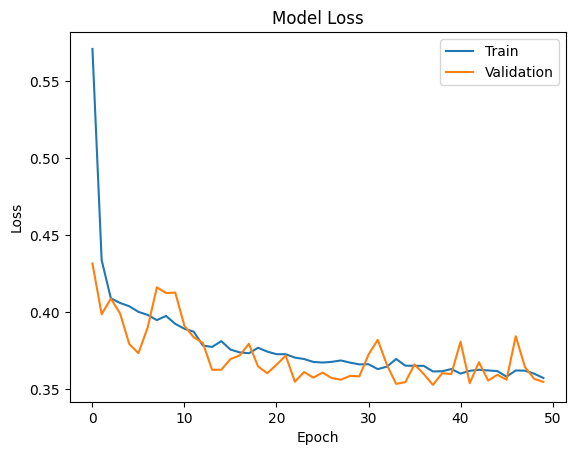

267/267 [==============================] - 1s 1ms/step
0.35482588
Test MSE: 14.700
Test RMSE: 3.834
Test MAE: 2.671
Test MAPE: 50.414


In [13]:
model, yhat = model_cnn_lstm(train_X, train_y, test_X, test_y)

In [14]:
layer_names = [layer.name for layer in model.layers]
print(layer_names)

['time_distributed', 'time_distributed_1', 'time_distributed_2', 'time_distributed_3', 'time_distributed_4', 'lstm', 'lstm_1', 'dense', 'dropout', 'dense_1']


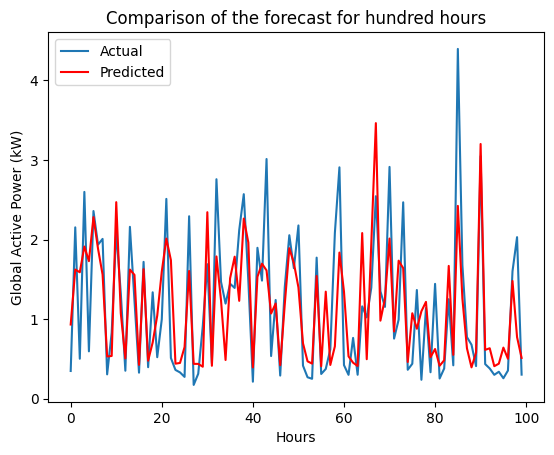

In [15]:
plt.figure()
plt.plot(test_y[:100],label = 'Actual')
plt.plot(yhat[:100],label = 'Predicted', color='red')
plt.xlabel('Hours')
plt.ylabel('Global Active Power (kW)')
plt.title('Comparison of the forecast for hundred hours')
plt.legend()
plt.show()

In [16]:
sixty_data = test_y[:60]

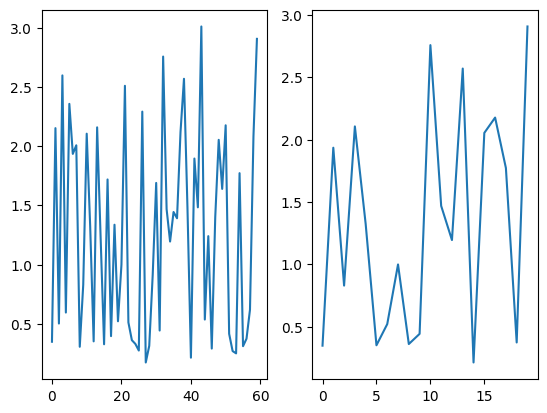

In [30]:
plt.subplot(1, 2, 1)
plt.plot(sixty_data)

sorted_sample = [
    sixty_data[i] for i in sorted(random.sample(range(len(sixty_data)), 20))
]
plt.subplot(1,2,2)
plt.plot(sorted_sample)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 6, 64)      192       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 3, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 2, 64)      8256      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 64)         0